# Loading the Dataset

You can download the dataset from {https://darwin.v7labs.com/v7-labs/covid-19-chest-x-ray-dataset?sort=priority\%3Adesc}.
The data entitled as '`darwin dataset pull v7-labs/covid-19-chest-x-ray-dataset:all-images`' will be used in this assignment. All dataset consist of 6504 images from 702 classes. We will extract the images of 4 classes (Bacterial Pneumonia, Viral Pneumonia, No Pneumonia (healthy), Covid-19) and save them as .npy file with the following code:

In [ ]:
from google.colab import drive
drive.mount('/Drive')

Mounted at /Drive


In [ ]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras import layers, models
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from itertools import cycle

import seaborn as sns

import matplotlib.pyplot as plt
import json
import numpy as np
import glob
import pandas as pd

import urllib.request
from PIL import Image

In [ ]:
def visualize_data(data, categories, class_names):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('white')
    for i in range(3 * 7):
        plt.subplot(3, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(data[i])
        class_index = categories[i].argmax()
        plt.xlabel(class_names[class_index])
    plt.show()
    #Code adapted from https://stepup.ai/train_data_augmentation_keras/

In [ ]:

def plot_history(result):
    result_dict = result.history
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,6))
    fig.tight_layout(h_pad=4)

    data_list_acc = [result_dict["accuracy"], result_dict["val_accuracy"]]
    label_list_acc = ['Training acc.', 'Validation acc.']
    epochs = range(1, len(data_list_acc[0]) + 1)

    for data_acc, label_acc in zip(data_list_acc, label_list_acc):
        axs[0].plot(epochs, data_acc, label=label_acc)
    axs[0].set_title('Training and validation accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    data_list_loss = [result_dict["loss"], result_dict["val_loss"]]
    label_list_loss = ['Training loss', 'Validation loss']

    for data_loss, label_loss in zip(data_list_loss, label_list_loss):
        axs[1].plot(epochs, data_loss, label=label_loss)
    axs[1].set_title('Training and validation loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    fig.show()

In [ ]:
def plot_roc_curve(model, X_test, y_test):

  y_pred = model.predict(X_test)
  fig, ax = plt.subplots(figsize=(10, 10))

  fpr, tpr, roc_auc = dict(), dict(), dict()
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
  )

  for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  fpr_grid = np.linspace(0.0, 1.0, 1000)

  mean_tpr = np.zeros_like(fpr_grid)
  for i in range(num_classes):
      mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  

  mean_tpr /= num_classes
  fpr["macro"] = fpr_grid
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
  )

  colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])

  for class_id, color in zip(range(num_classes), colors):
      RocCurveDisplay.from_predictions(
          y_test[:, class_id],
          y_pred[:, class_id],
          name=f"ROC curve for {np.unique(labels)[class_id]}",
          color=color,
          ax=ax,
      )

  plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Operating Characteristic\n One-vs-Rest multiclass")
  plt.legend()
  plt.show()

  #Code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [ ]:
def plotting_confusion_matrix(model, X_test, y_test):

  y_pred = model.predict(X_test)
  y_pred = (y_pred > 0.5).astype('float32')

  cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
  

  fig, axes= plt.subplots(figsize=(10, 10))
  sns.heatmap(cm, annot=True, fmt='g', ax=axes);  #with ftm='g' we disable scientific notation
  axes.set_xlabel('Predicted labels')
  axes.set_ylabel('True labels')
  axes.set_title('Confusion Matrix')
  axes.xaxis.set_ticklabels(['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)', 'Viral Pneumonia'])
  axes.yaxis.set_ticklabels(['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)', 'Viral Pneumonia'])

  fig.show()

  #Code adapted from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

In [ ]:
def performance_metrics(model):
  classes = {0:'Bacterial Pneumonia', 1:'COVID-19', 2:'No Pneumonia (healthy)', 3:'Viral Pneumonia'}
  y_pred = model.predict(X_test)
  y_pred = (y_pred > 0.5).astype('float32')

  cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

  for i in range(num_classes):
    TP = cm[i,i]
    FP = sum(cm[:,i]) - cm[i,i]
    FN = sum(cm[i,:]) - cm[i,i]
    TN = sum(np.delete(sum(cm)-cm[i,:],i))

    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    specificity = TN/(TN+FP)
    f1_score_ = 2*((precision*recall)/(precision+recall))
    accuracy = (TP+TN)/(TP+FP+TN+FN)

    message= f'Class {classes[i]}: \nSpecificity :{round(specificity,4)}\nSensitivity: {round(recall,4)}\nF1-score: {round(f1_score_,4)}\nAccuracy: {round(accuracy,4)}\n'
    print(message)
  
  f1_micro = f1_score(y_test, y_pred, average='micro')
  print(f"\nF1 micro average: {f1_micro}")

    #Code adapted from https://gist.github.com/emadeldeen24/1da8b1ce98622d5990f35db6a0d3018d


Once you save your data, you can load it from your directory.

In [ ]:
data = np.load('/Drive/MyDrive/Group10DeepLearning/data/data.npy')
labels = np.load('/Drive/MyDrive/Group10DeepLearning/data/labels.npy')

# Preprocessing Steps



In [ ]:
#Checking the type of target data
num_classes=len(np.unique(labels))
print(num_classes)
np.unique(labels)

#Transform the target labels into integers to enable using "to_categorical" later:
le = preprocessing.LabelEncoder()

le.fit(labels)

list(le.classes_)
print(list(le.classes_))

labels_transformed = le.transform(labels)

print(labels_transformed)

4
['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)', 'Viral Pneumonia']
[2 0 3 ... 0 0 0]


In [ ]:
np.unique(labels, return_counts = True)

(array(['Bacterial Pneumonia', 'COVID-19', 'No Pneumonia (healthy)',
        'Viral Pneumonia'], dtype='<U22'), array([2816,  521, 1606, 1970]))

Text(0.5, 1.0, 'Class imbalance')

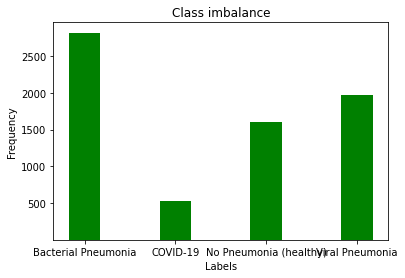

In [ ]:
x = np.unique(labels, return_counts = True)[-1]
index = np.arange(num_classes) 
bar_width = 0.35
opacity = 0.4


plt.bar(index, x, bar_width, opacity, color='g')
plt.xticks(index, np.unique(labels))

plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Class imbalance')


## Splitting Data & One-hot encode

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(data, labels_transformed, test_size = 0.2, stratify=labels_transformed, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.25, stratify=y_trainval, random_state = 42)

print(X_train.shape, X_val.shape, X_test.shape)

# Convert a class vector (integers) to binary class matrix.
y_train = to_categorical(y_train) 
y_test = to_categorical(y_test)
y_val = to_categorical(y_val) 
y_trainval = to_categorical(y_trainval) 

(4147, 156, 156, 3) (1383, 156, 156, 3) (1383, 156, 156, 3)


## Normalize Data

In [ ]:
# convert from integers to floats
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
X_trainval = X_trainval.astype('float32')

# normalize to range 0-1 (Use 255 because this is the highest possible value)
X_train.max()

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0
X_trainval = X_trainval / 255.0

## Visualization

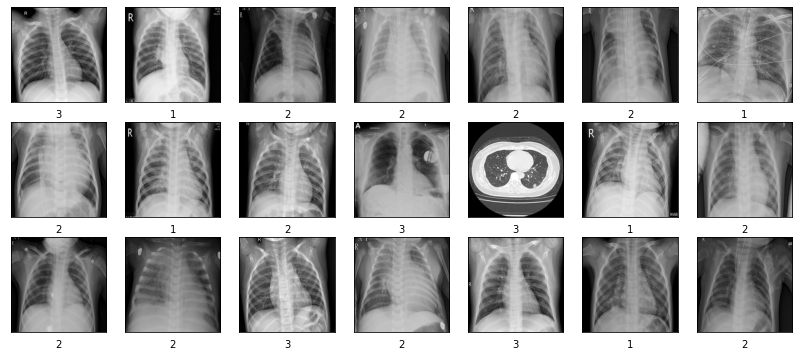

In [ ]:
visualize_data(X_train, y_train, labels_transformed)

## Data Augmentation

In [ ]:
width_shift = 0.1 
height_shift = 0.1
flip = True


datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
    )
datagen.fit(X_train)

augmented_data = datagen.flow(X_train, y_train, shuffle=False)

datagen2 = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
    )
datagen2.fit(X_trainval)

augmented_data_full = datagen2.flow(X_trainval, y_trainval, shuffle=False)

# Baseline Model

In [ ]:
model = Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape = X_train.shape[1:], padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 156, 156, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 156, 156, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 78, 78, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 78, 78, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                    

In [ ]:
result = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
130/130 [==============================] - 22s 79ms/step - loss: 0.9051 - accuracy: 0.5934 - val_loss: 0.7317 - val_accuracy: 0.6710
Epoch 2/10
130/130 [==============================] - 8s 63ms/step - loss: 0.6508 - accuracy: 0.7157 - val_loss: 0.6993 - val_accuracy: 0.6768
Epoch 3/10
130/130 [==============================] - 8s 63ms/step - loss: 0.6112 - accuracy: 0.7232 - val_loss: 0.6499 - val_accuracy: 0.7101
Epoch 4/10
130/130 [==============================] - 9s 67ms/step - loss: 0.5725 - accuracy: 0.7374 - val_loss: 0.6468 - val_accuracy: 0.7137
Epoch 5/10
130/130 [==============================] - 9s 68ms/step - loss: 0.5059 - accuracy: 0.7678 - val_loss: 0.6575 - val_accuracy: 0.6970
Epoch 6/10
130/130 [==============================] - 9s 69ms/step - loss: 0.4662 - accuracy: 0.7849 - val_loss: 0.6852 - val_accuracy: 0.6941
Epoch 7/10
130/130 [==============================] - 8s 64ms/step - loss: 0.4083 - accuracy: 0.8097 - val_loss: 0.7030 - val_accuracy: 0.695

## Model Performance

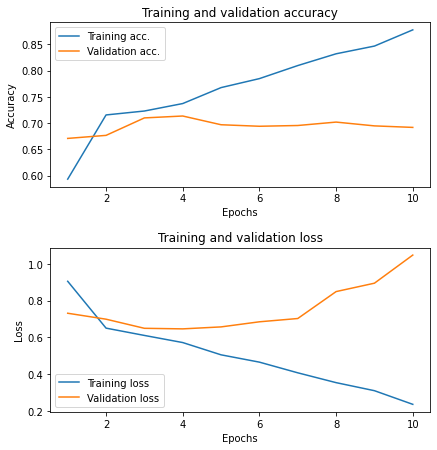

In [ ]:
plot_history(result)

44/44 [==============================] - 1s 16ms/step


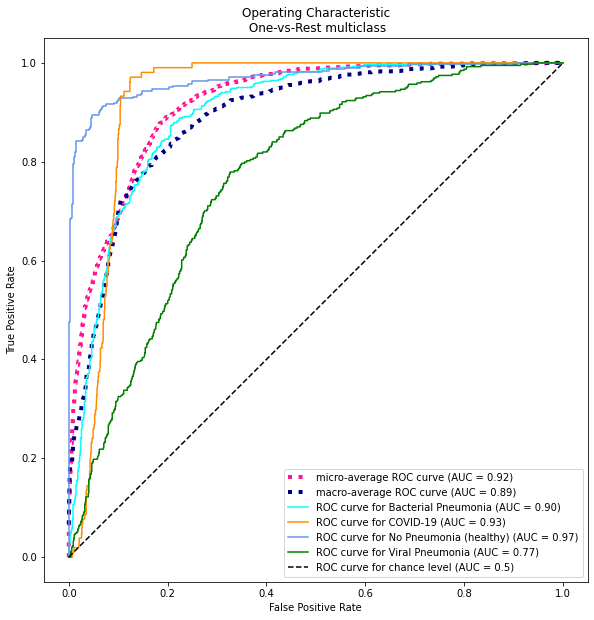

In [ ]:
plot_roc_curve(model, X_val, y_val)

44/44 [==============================] - 1s 17ms/step


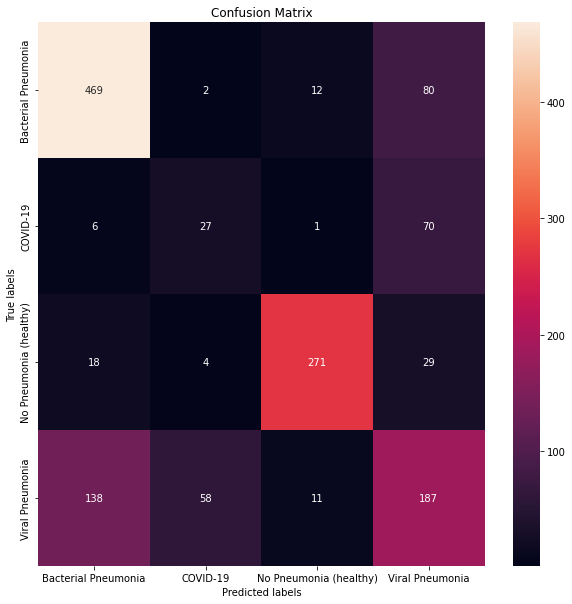

In [ ]:
plotting_confusion_matrix(model, X_val, y_val)

## Retraining the baseline model

Training the model on validation and training data combined. 

In [ ]:
result_tv = model.fit(X_trainval, y_trainval, epochs=10, batch_size=32)

Epoch 1/10
173/173 [==============================] - 12s 67ms/step - loss: 0.3818 - accuracy: 0.8436
Epoch 2/10
173/173 [==============================] - 11s 61ms/step - loss: 0.2659 - accuracy: 0.8770
Epoch 3/10
173/173 [==============================] - 10s 60ms/step - loss: 0.2018 - accuracy: 0.8935
Epoch 4/10
173/173 [==============================] - 10s 60ms/step - loss: 0.1608 - accuracy: 0.9074
Epoch 5/10
173/173 [==============================] - 11s 65ms/step - loss: 0.1645 - accuracy: 0.9042
Epoch 6/10
173/173 [==============================] - 10s 60ms/step - loss: 0.1457 - accuracy: 0.9090
Epoch 7/10
173/173 [==============================] - 10s 61ms/step - loss: 0.1386 - accuracy: 0.9134
Epoch 8/10
173/173 [==============================] - 10s 60ms/step - loss: 0.1287 - accuracy: 0.9145
Epoch 9/10
173/173 [==============================] - 10s 60ms/step - loss: 0.1217 - accuracy: 0.9222
Epoch 10/10
173/173 [==============================] - 10s 60ms/step - loss: 0.130

## Baseline Model Performance

44/44 [==============================] - 1s 16ms/step


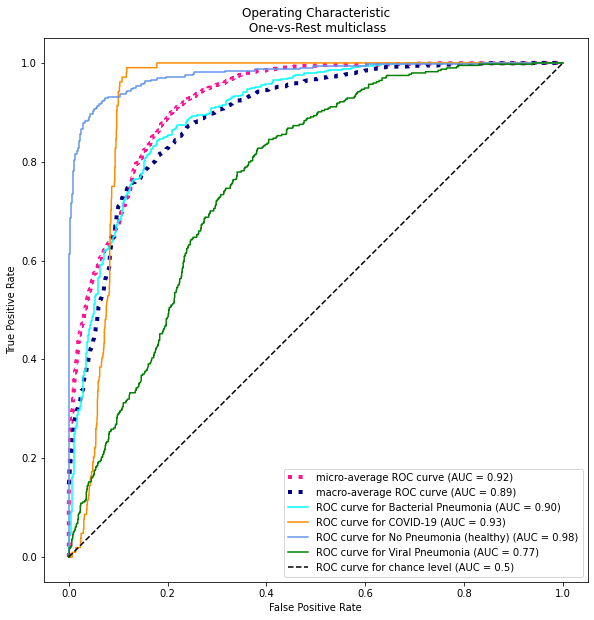

In [ ]:
plot_roc_curve(model, X_test, y_test)

44/44 [==============================] - 1s 17ms/step


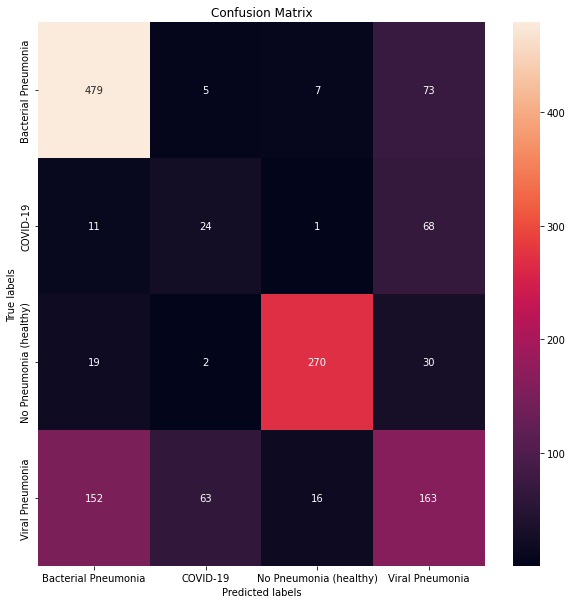

In [ ]:
plotting_confusion_matrix(model, X_test, y_test)

Performance metrics

In [ ]:
performance_metrics(model)

44/44 [==============================] - 1s 16ms/step
Class Bacterial Pneumonia: 
Specificity :0.7778
Sensitivity: 0.8493
F1-score: 0.782
Accuracy: 0.8069

Class COVID-19: 
Specificity :0.9453
Sensitivity: 0.2308
F1-score: 0.2424
Accuracy: 0.8915

Class No Pneumonia (healthy): 
Specificity :0.9774
Sensitivity: 0.8411
F1-score: 0.878
Accuracy: 0.9458

Class Viral Pneumonia: 
Specificity :0.8271
Sensitivity: 0.4137
F1-score: 0.4478
Accuracy: 0.7093


F1 micro average: 0.6829981718464352


In [ ]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 1s 20ms/step - loss: 1.0045 - accuracy: 0.6855


[1.0044705867767334, 0.6854663491249084]

## Fine-tuned Model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 156, 156, 64)      1792      
                                                                 
 conv2d_19 (Conv2D)          (None, 156, 156, 32)      18464     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 78, 78, 32)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 78, 78, 32)        9248      
                                                                 
 conv2d_21 (Conv2D)          (None, 78, 78, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 39, 39, 32)       0         
 g2D)                                                 

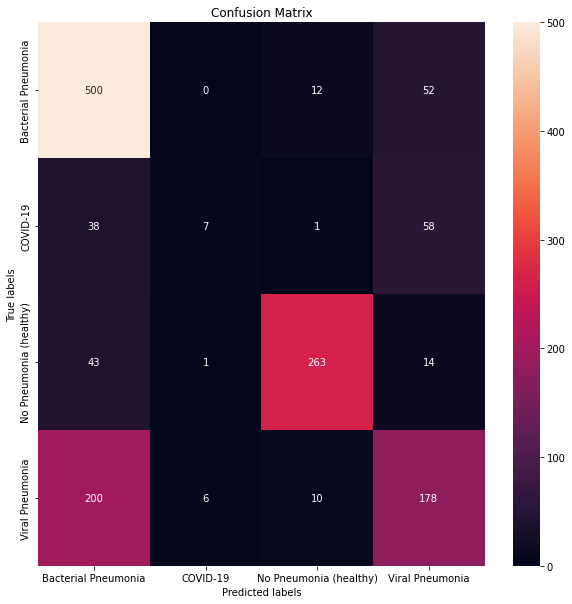

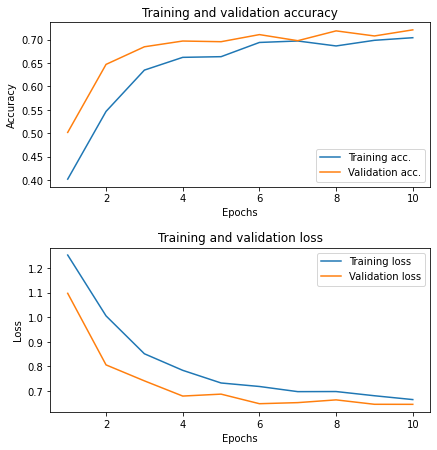

In [ ]:
#Training the model on 10 epochs to explore if it may be efficient
model_aug_final_drop = Sequential()

model_aug_final_drop.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape = X_train.shape[1:], padding='same'))
model_aug_final_drop.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.MaxPooling2D((2, 2)))

model_aug_final_drop.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.MaxPooling2D((2, 2)))

model_aug_final_drop.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.MaxPooling2D((2, 2)))

model_aug_final_drop.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.MaxPooling2D((2, 2)))

model_aug_final_drop.add(layers.Flatten())

model_aug_final_drop.add(layers.Dense(64, activation='relu'))
model_aug_final_drop.add(layers.Dropout(0.2))

model_aug_final_drop.add(layers.Dense(32, activation='relu'))

model_aug_final_drop.add(layers.Dense(4, activation='softmax'))
model_aug_final_drop.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
model_aug_final_drop.summary()
result_aug_final_withdrop = model_aug_final_drop.fit(augmented_data, epochs=10, batch_size=32, validation_data=(X_val, y_val))

print(plotting_confusion_matrix(model_aug_final_drop, X_test, y_test))
print(performance_metrics(model_aug_final_drop))
model_aug_final_drop.evaluate(X_test, y_test)
plot_history(result_aug_final_withdrop)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 156, 156, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 156, 156, 32)      18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 78, 78, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 78, 78, 32)        9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 78, 78, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                  

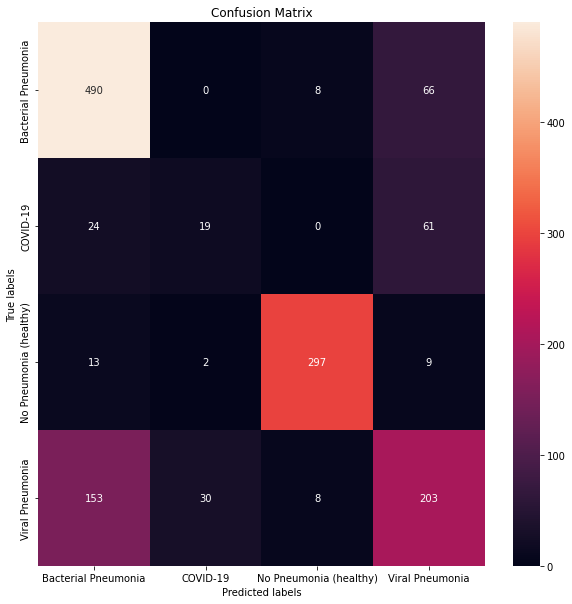

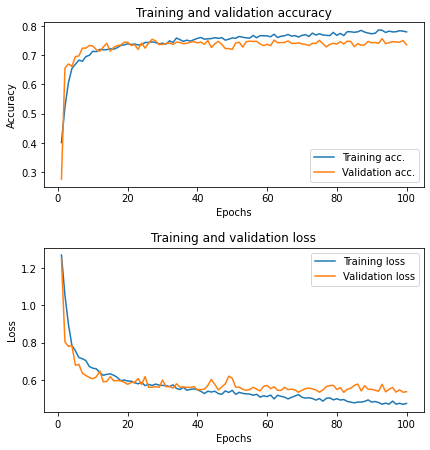

In [ ]:
#Retraining the model for 100 epochs to find the ideal amount of epochs
model_aug_final_drop = Sequential()

model_aug_final_drop.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape = X_train.shape[1:], padding='same'))
model_aug_final_drop.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.MaxPooling2D((2, 2)))

model_aug_final_drop.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.MaxPooling2D((2, 2)))

model_aug_final_drop.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.MaxPooling2D((2, 2)))

model_aug_final_drop.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.MaxPooling2D((2, 2)))

model_aug_final_drop.add(layers.Flatten())

model_aug_final_drop.add(layers.Dense(64, activation='relu'))
model_aug_final_drop.add(layers.Dropout(0.2))

model_aug_final_drop.add(layers.Dense(32, activation='relu'))

model_aug_final_drop.add(layers.Dense(4, activation='softmax'))
model_aug_final_drop.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
model_aug_final_drop.summary()
result_aug_final_withdrop = model_aug_final_drop.fit(augmented_data, epochs=100, batch_size=32, validation_data=(X_val, y_val))

print(plotting_confusion_matrix(model_aug_final_drop, X_test, y_test))
print(performance_metrics(model_aug_final_drop))
model_aug_final_drop.evaluate(X_test, y_test)
plot_history(result_aug_final_withdrop)

44/44 [==============================] - 1s 15ms/step


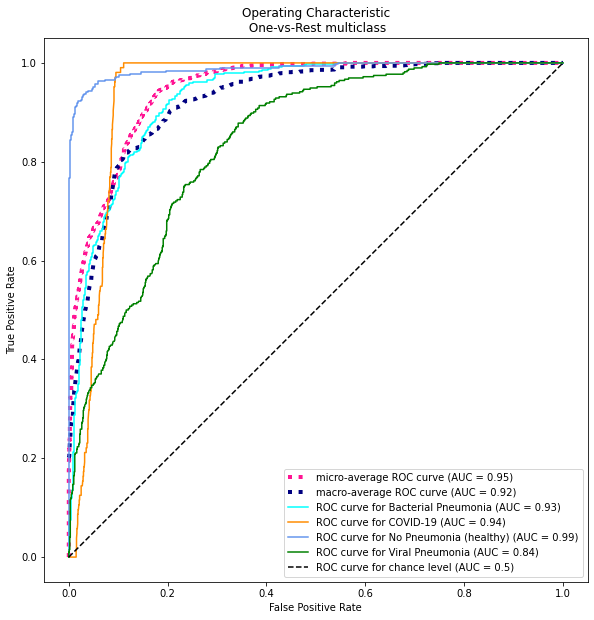

In [ ]:
plot_roc_curve(model_aug_final_drop, X_val, y_val)

## Training the final model on train+val + augmented data 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 156, 156, 64)      1792      
                                                                 
 conv2d_13 (Conv2D)          (None, 156, 156, 32)      18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 78, 78, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 78, 78, 32)        9248      
                                                                 
 conv2d_15 (Conv2D)          (None, 78, 78, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                  

[0.5357813239097595, 0.7411424517631531]

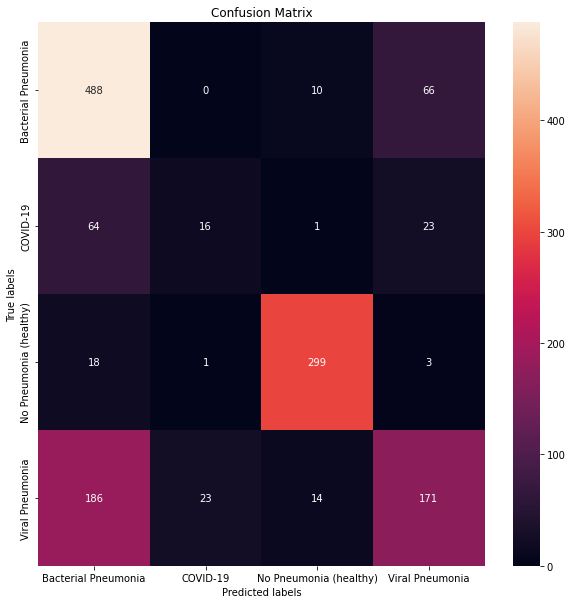

In [ ]:
#Training the model on augmented data that combines training and validation data  
model_aug_final_drop = Sequential()

model_aug_final_drop.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape = X_train.shape[1:], padding='same'))
model_aug_final_drop.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.MaxPooling2D((2, 2)))

model_aug_final_drop.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.MaxPooling2D((2, 2)))

model_aug_final_drop.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.MaxPooling2D((2, 2)))

model_aug_final_drop.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_aug_final_drop.add(layers.MaxPooling2D((2, 2)))

model_aug_final_drop.add(layers.Flatten())

model_aug_final_drop.add(layers.Dense(64, activation='relu'))
model_aug_final_drop.add(layers.Dropout(0.2))

model_aug_final_drop.add(layers.Dense(32, activation='relu'))

model_aug_final_drop.add(layers.Dense(4, activation='softmax'))
model_aug_final_drop.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
model_aug_final_drop.summary()
result_aug_final_withdrop = model_aug_final_drop.fit(augmented_data_full, epochs=40, batch_size=32)

print(plotting_confusion_matrix(model_aug_final_drop, X_test, y_test))
print(performance_metrics(model_aug_final_drop))
model_aug_final_drop.evaluate(X_test, y_test)

44/44 [==============================] - 1s 20ms/step


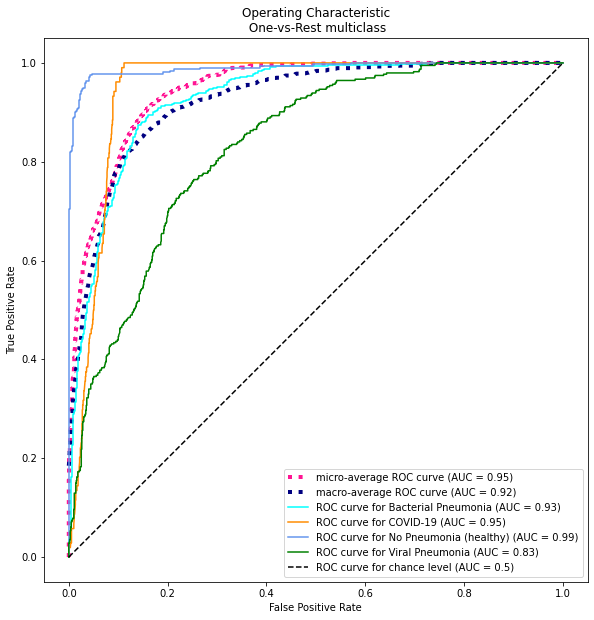

In [ ]:
plot_roc_curve(model_aug_final_drop, X_test, y_test)

# Transfer Learning

In [ ]:
from keras.applications.vgg16 import VGG16
vgg_model = VGG16()
vgg_model.summary()

553467096/553467096 [==============================] - 26s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
vgg_model = VGG16(include_top=False, input_shape=(X_train.shape[1:]))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
for layer in vgg_model.layers:
  layer.trainable = False

In [ ]:
flat1 = layers.Flatten()(vgg_model.layers[-1].output)
class1 = layers.Dense(128, activation='relu')(flat1)
output = layers.Dense(4, activation='softmax')(class1)
vgg_model = Model(inputs=vgg_model.inputs, outputs=output)
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 156, 156, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 156, 156, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 156, 156, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 78, 78, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 78, 78, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 78, 78, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 39, 39, 128)       0     

In [ ]:
vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = vgg_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=10, batch_size=32,verbose=1)


Epoch 1/10
130/130 [==============================] - 28s 127ms/step - loss: 0.7249 - accuracy: 0.6925 - val_loss: 0.6840 - val_accuracy: 0.7101
Epoch 2/10
130/130 [==============================] - 14s 111ms/step - loss: 0.5522 - accuracy: 0.7608 - val_loss: 0.7426 - val_accuracy: 0.7057
Epoch 3/10
130/130 [==============================] - 13s 98ms/step - loss: 0.4910 - accuracy: 0.7813 - val_loss: 0.6093 - val_accuracy: 0.7339
Epoch 4/10
130/130 [==============================] - 13s 100ms/step - loss: 0.4504 - accuracy: 0.8027 - val_loss: 0.6072 - val_accuracy: 0.7187
Epoch 5/10
130/130 [==============================] - 13s 99ms/step - loss: 0.4174 - accuracy: 0.8093 - val_loss: 0.6529 - val_accuracy: 0.7072
Epoch 6/10
130/130 [==============================] - 15s 112ms/step - loss: 0.3949 - accuracy: 0.8172 - val_loss: 0.6566 - val_accuracy: 0.7252
Epoch 7/10
130/130 [==============================] - 12s 95ms/step - loss: 0.3617 - accuracy: 0.8363 - val_loss: 0.6246 - val_accur

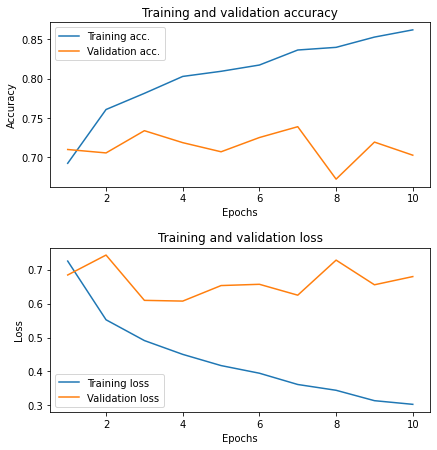

In [ ]:
plot_history(history)

In [ ]:
history_tv = vgg_model.fit(X_trainval, y_trainval, epochs=10, batch_size=32,verbose=1)


Epoch 1/10
173/173 [==============================] - 14s 82ms/step - loss: 0.3847 - accuracy: 0.8248
Epoch 2/10
173/173 [==============================] - 13s 74ms/step - loss: 0.3401 - accuracy: 0.8407
Epoch 3/10
173/173 [==============================] - 13s 73ms/step - loss: 0.3300 - accuracy: 0.8400
Epoch 4/10
173/173 [==============================] - 12s 72ms/step - loss: 0.2883 - accuracy: 0.8579
Epoch 5/10
173/173 [==============================] - 12s 72ms/step - loss: 0.2951 - accuracy: 0.8542
Epoch 6/10
173/173 [==============================] - 12s 72ms/step - loss: 0.2695 - accuracy: 0.8694
Epoch 7/10
173/173 [==============================] - 12s 72ms/step - loss: 0.2436 - accuracy: 0.8731
Epoch 8/10
173/173 [==============================] - 12s 72ms/step - loss: 0.2455 - accuracy: 0.8736
Epoch 9/10
173/173 [==============================] - 13s 72ms/step - loss: 0.2288 - accuracy: 0.8819
Epoch 10/10
173/173 [==============================] - 13s 72ms/step - loss: 0.215

44/44 [==============================] - 3s 71ms/step


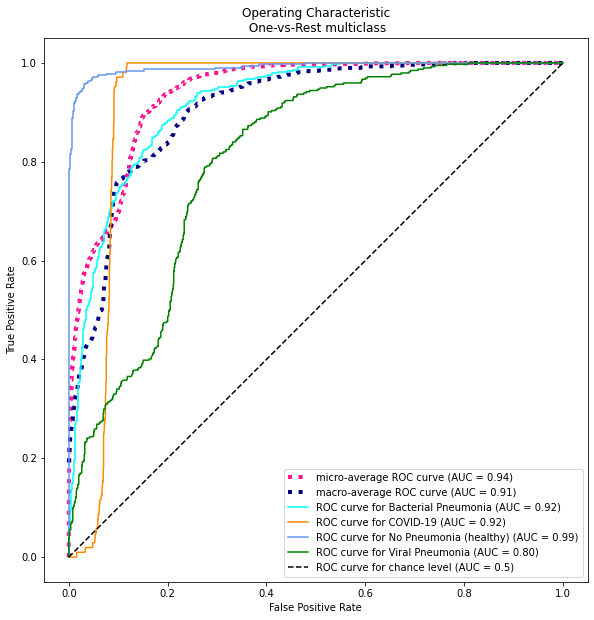

In [ ]:
plot_roc_curve(vgg_model, X_test, y_test)

44/44 [==============================] - 3s 71ms/step


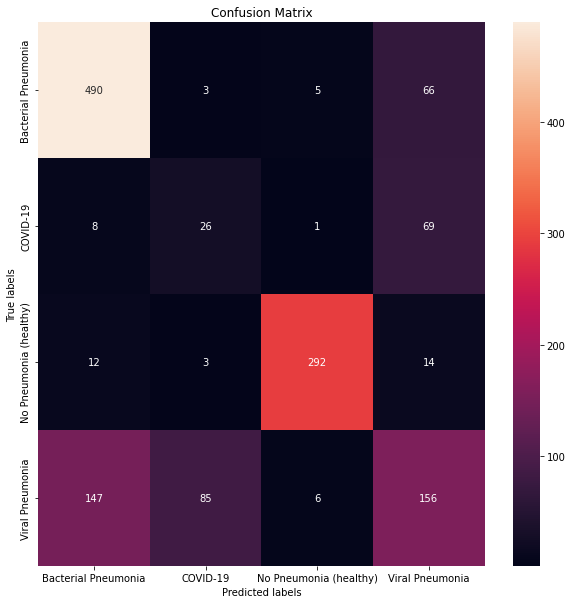

In [ ]:
plotting_confusion_matrix(vgg_model, X_test, y_test)

In [ ]:
print(performance_metrics(vgg_model))
vgg_model.evaluate(X_test, y_test)

44/44 [==============================] - 3s 70ms/step
Class Bacterial Pneumonia: 
Specificity :0.7961
Sensitivity: 0.8688
F1-score: 0.8026
Accuracy: 0.8257

Class COVID-19: 
Specificity :0.9289
Sensitivity: 0.25
F1-score: 0.2353
Accuracy: 0.8778

Class No Pneumonia (healthy): 
Specificity :0.9887
Sensitivity: 0.9097
F1-score: 0.9344
Accuracy: 0.9704

Class Viral Pneumonia: 
Specificity :0.8493
Sensitivity: 0.3959
F1-score: 0.4464
Accuracy: 0.7202


F1 micro average: 0.6994535519125683
None
44/44 [==============================] - 3s 71ms/step - loss: 0.7322 - accuracy: 0.6992


[0.7322291135787964, 0.6992046236991882]